# Prism data processing

### Setup

#### Ensuring Reproducibility with Seeds




In [3]:
seed_value=42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

In [4]:
import pandas as pd

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from tqdm.auto import trange

from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression, f_regression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization, Input, Activation, Concatenate
from tensorflow.keras import layers, optimizers, callbacks, Model
from keras.initializers import zeros
import keras_tuner as kt
from keras import backend as K

In [5]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import propagators
from pyGDM2 import core
from pyGDM2 import visu
from pyGDM2 import tools
from pyGDM2 import linear

In [6]:
plt.rcParams.update({
   "font.family": "serif",  # use serif/main font for text elements
   "text.usetex": True,     # use inline math for ticks
   "pgf.rcfonts": False     # don't setup fonts from rc parameters
   })

### Read and display data

In [7]:
df1=pd.read_csv(r'prism_dataset.csv')
df1

,length,height,edge,ni,thetax,thetay,thetaz,Ext. maxima,wavelgth ext. max.,Sca. maxima,wavelgth sca. max.,Abs. maxima,wavelgth abs. max.,EF. maxima,wavelgth ef. max.
0,137.0,14.7,0.81,1.84,27.0,6.0,15.0,35496.257023,838.0,12917.745126,838.0,22578.511897,838.0,1.286153,862.0
1,134.0,16.2,0.89,1.94,48.0,39.0,33.0,12977.941537,868.0,4275.411517,865.0,8730.240013,868.0,1.104350,907.0
2,156.0,19.3,0.82,1.33,27.0,90.0,27.0,1752.227703,508.0,114.708661,523.0,1648.593840,505.0,1.028197,559.0
3,131.0,18.0,0.81,1.64,66.0,69.0,3.0,25879.449014,736.0,8787.740190,730.0,17142.814271,736.0,1.168914,766.0
4,138.0,10.0,0.33,1.38,27.0,36.0,12.0,22717.188788,808.0,4969.636688,808.0,17751.289608,805.0,1.175315,808.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,112.0,9.8,0.72,1.90,51.0,39.0,57.0,8040.319155,862.0,2841.506976,859.0,5207.675465,862.0,1.066583,892.0
1020,64.0,16.0,0.37,1.27,18.0,81.0,54.0,3454.676109,610.0,316.395760,613.0,3145.961656,607.0,1.035611,619.0
1021,142.0,15.1,0.23,1.98,57.0,54.0,87.0,4836.022147,775.0,1277.052391,772.0,3590.933190,775.0,1.022872,424.0
1022,138.0,20.0,0.74,1.99,72.0,48.0,78.0,4695.058647,511.0,1226.458577,880.0,4109.071210,511.0,1.039708,466.0


Defining the different sets

In [6]:
Obs=df[['length','height','edge','ni','thetax','thetay','thetaz','wavelgth ext. max.']]
Qst=df[['wavelgth ext. max.']]
Ans=df[['length','height','edge','ni','thetax','thetay','thetaz']]
Obs_train, Obs_test, Qst_train, Qst_test, Ans_train, Ans_test = train_test_split(Obs, Qst, Ans, test_size=0.2, random_state=42)

Assesssing the range of calculated LSPR

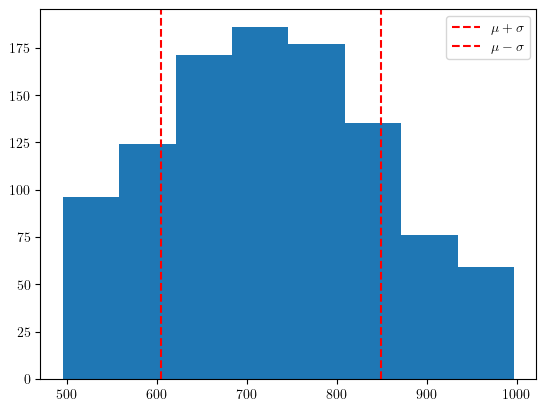

In [9]:
plt.figure()
plt.hist(Qst,bins=8)
std1,std2=Qst.mean()+Qst.std(),Qst.mean()-Qst.std()
std1,std2=std1[0],std2[0]
plt.axvline(x=std1,color='r',linestyle='--',label='$\mu+\sigma$')
plt.axvline(x=std2,color='r',linestyle='--',label='$\mu-\sigma$')
plt.legend()
plt.show()


# Human reasoning inspired VAE

Hyperparameter tuning

In [10]:
#Defining the sampling layer
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [11]:
def build_modeliVAE_prism(hp):

    """
    This function builds a variant of (VAE) model with variable number of layers, neurons, learning rate, and regularization parameter (beta).
    The structure includes an encoder that encodes the input into a latent representation, and a decoder that reconstructs the input from the latent representation.

    Arguments:
    hp -- Keras Tuner hyperparameters class instance, used for defining the model's architecture and learning rate

    Returns:
    The constructed VAE model with the defined architecture, loss function, optimizer, and learning rate.
    """

    n_layers = hp.Int('n_layers', min_value=1, max_value=4, default=2)
    n_neurons_en = hp.Int("n_neurons_en", min_value=4, max_value=400)
    n_neurons_de = hp.Int("n_neurons_de", min_value=4, max_value=400)
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2,sampling="log")
    beta = hp.Float("beta", min_value=1e-6, max_value=1e6,sampling="log")

    #encoder
    codings_size = 2
    inputs = Input(shape=[8])
    norm_codings = Normalization()
    Z=norm_codings(inputs)
    for layer in range(n_layers):
        Z = Dense(n_neurons_en, activation="swish",kernel_initializer="he_normal")(Z)
    codings_mean = Dense(codings_size)(Z) # μ
    codings_log_var = Dense(codings_size,kernel_initializer=zeros())(Z) # γ
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

    #decoder
    question_inputs = Input(shape=[1])
    norm_question = Normalization()
    q=norm_question(question_inputs)
    decoder_inputs = Input(shape=[codings_size]) 
    x= Concatenate()([decoder_inputs, q])
    for layer in range(n_layers):
        x = Dense(n_neurons_de, activation="swish",kernel_initializer="he_normal")(x)
    outputs = Dense(7)(x) #Answer size
    variational_decoder = Model(inputs=[question_inputs,decoder_inputs], outputs=[outputs])

    #VAE
    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(inputs=[question_inputs,codings])
    model = Model(inputs=[inputs,question_inputs], outputs=[reconstructions])

    #latent loss
    latent_loss = -beta*0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),axis=-1)
    model.add_loss(tf.reduce_mean(latent_loss) / 7.)

    #compile and train
    model.compile(loss="mse", optimizer=optimizers.Adam(learning_rate),metrics=["accuracy"])
    return model
    


In [63]:
objective = kt.Objective("val_accuracy", direction="max")
#Use a bayesian tuner to find the best hyperparameters
bayesian_tuner = kt.BayesianOptimization(
    build_modeliVAE_prism,
    objective=objective,
    max_trials=20,
    overwrite=True,
    directory="hpiVAEprismV1",
    project_name="my_bayesian_search",
)
bayesian_tuner.search((Obs,Qst), Ans, epochs=4000,validation_split=0.2,batch_size=4,verbose=False)
bayesian_tuner.get_best_hyperparameters()[0].values

/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/keras_tuner/engine/metrics_tracking.py:107: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values) if self.direction == "min" else np.nanmax(values)
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/keras_tuner/engine/metrics_tracking.py:107: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values) if self.direction == "min" else np.nanmax(values)
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/keras_tuner/engine/metrics_tracking.py:107: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values) if self.direction == "min" else np.nanmax(values)
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/keras_tuner/engine/metrics_tracking.py:107: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values) if self.direction == "min" else np.nanmax(values)
/Users/eliasabboubi/opt/miniconda3/envs/

INFO:tensorflow:Oracle triggered exit


{'n_layers': 2,
 'n_neurons_en': 208,
 'n_neurons_de': 96,
 'learning_rate': 0.00011813628166902428,
 'beta': 1.1446332098116718}

### Building of the autoencoder

The principles utilized are essentially the same as those previously observed for the spheres. The primary difference lies in the dimensionality of the answer space, given that there are now seven parameters to predict instead of just two. There is no established method for predicting the dimension of the latent space, although it might be reasoned that a greater number of parameters to predict could necessitate a higher dimensional latent space.

In [39]:
#build
#encoder
beta=5*1e1
codings_size = 2
inputs = Input(shape=[8])
norm_codings = Normalization()
Z=norm_codings(inputs)
Z = Dense(200, activation="swish",kernel_initializer=tf.keras.initializers.HeNormal(seed=-seed_value))(Z)
Z = Dense(200, activation="swish",kernel_initializer=tf.keras.initializers.HeNormal(seed=seed_value))(Z)
codings_mean = Dense(codings_size,kernel_initializer=zeros())(Z) # μ
codings_log_var = Dense(codings_size,kernel_initializer=zeros())(Z) # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

#decoder
question_inputs = Input(shape=[1])
norm_question = Normalization()
q=norm_question(question_inputs)
decoder_inputs = Input(shape=[codings_size]) 
x= Concatenate()([decoder_inputs, q])
x = Dense(100, activation="swish",kernel_initializer=tf.keras.initializers.HeNormal(seed=-2*seed_value))(x)
x = Dense(100, activation="swish",kernel_initializer=tf.keras.initializers.HeNormal(seed=2*seed_value))(x)
outputs = Dense(7)(x) #Answer size
variational_decoder = Model(inputs=[question_inputs,decoder_inputs], outputs=[outputs])

#VAE
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(inputs=[question_inputs,codings])
variational_ae = Model(inputs=[inputs,question_inputs], outputs=[reconstructions])

#latent loss
latent_loss = -beta*0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 7.)

#compile and train
variational_ae.compile(loss="mse", optimizer=optimizers.Adam(1e-3))
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=500)
norm_codings.adapt(Obs)
norm_question.adapt(Qst)
history = variational_ae.fit((Obs,Qst), Ans, epochs=4000,validation_split=0.2,callbacks=[lr_scheduler],batch_size=1,verbose=False)


### Learning process through epochs

7/7 [==============================] - 0s 892us/step


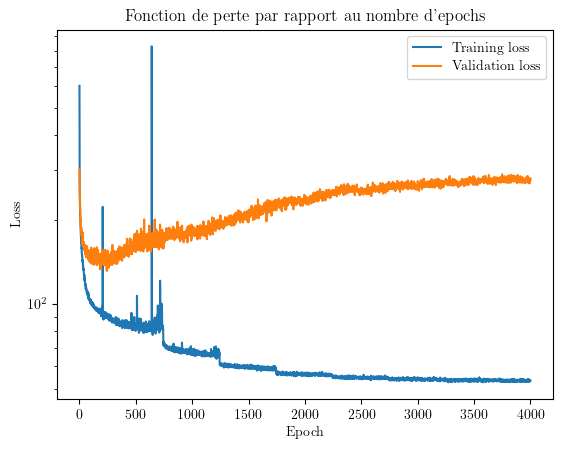

RMSE 10.729846248893892 MAE 3.680650000599619


In [41]:
#evaluate
mse_ivaec = variational_ae.evaluate((Obs_test,Qst_test), Ans_test)
rmse_ivaec=np.sqrt(mse_ivaec)
mae_ivaec=mean_absolute_error(Ans_test,variational_ae.predict((Obs_test,Qst_test)))
rmse_ivaec,mae_ivaec

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Fonction de perte par rapport au nombre d\'epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss','Validation loss'])
plt.show()

print('RMSE',rmse_ivaec,'MAE',mae_ivaec)

### Performance scheduling

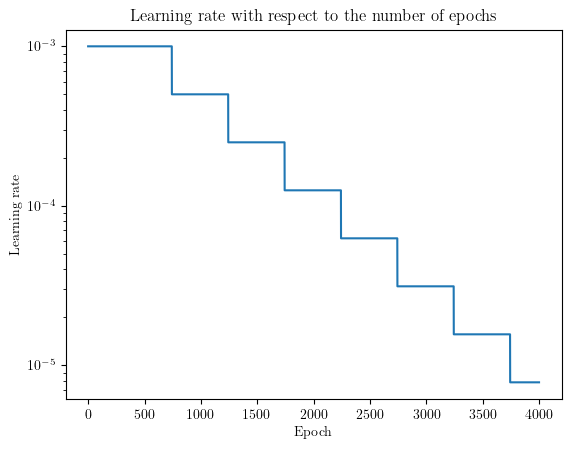

In [42]:
plt.semilogy(history.history["lr"])
plt.title('Learning rate with respect to the number of epochs')
plt.ylabel('Learning rate')
plt.xlabel('Epoch')
plt.show()

# Latent representation

With our model, the latent space have 2 dimensions instead of one for the spheres. In the same way, the latent representation should looks like a normal distribution $\mathcal{N}(\mu=0,\sigma=1)$.

32/32 [==============================] - 0s 488us/step


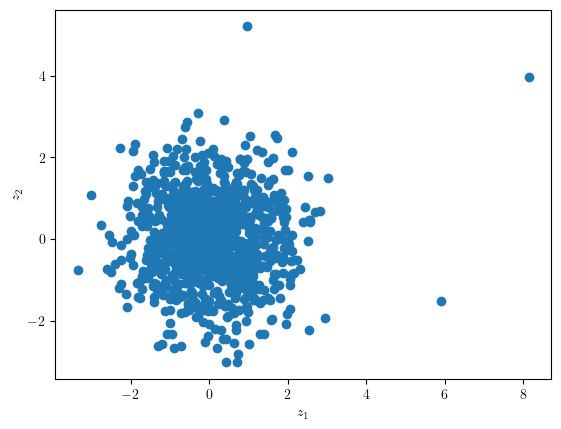

sigma z1 1.0673931 sigma z2 1.0351195 mean z1 0.030869927 mean z2 0.033459414


In [70]:
z1,z2=np.array(variational_encoder.predict(Obs))[2,:,0],np.array(variational_encoder.predict(Obs))[2,:,1]
plt.scatter(z1,z2)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

plt.show()
np.std(z1),np.std(z2),np.mean(z1),np.mean(z2)
print('sigma z1',np.std(z1),'sigma z2',np.std(z2),'mean z1',np.mean(z1),'mean z2',np.mean(z2))

### Statistical independant representation test

An important point for a multi-dimesional latent space is that if every dimension of the space represent a physical parameter, it is needed to ensure that each dimension is independant. Raising the $\beta$ coefficient is a strategy to do so since it will force the latent space to be more gaussian and then to have more independant dimensions. To measure how independant are the dimensions, the correlation coefficient and the Fisher test are not really adapted since they are not able to detect non-linear relationship. A better way is to use the mutual information (and so the normalized distance information) which is able to detect any kind of relationship. 

In [71]:
corr_lin_score=np.corrcoef(z1,z2)
MI_score=mutual_info_regression(z1.reshape(-1,1),z2)
F_score,_=f_regression(z1.reshape(-1,1),z2)
print('Correlation coefficient',corr_lin_score[0,1],'Mutual information',MI_score[0], 'F test',F_score[0])

Correlation coefficient -0.0008900604859750394 Mutual information 0.0008142736119332028 F test 0.0008096373470031242


### Normalized distance information

In [72]:
def info_dist(z1, z2, n_neighbors=1):
    """
    This function calculates the 'information distance' between two 1D arrays, `z1` and `z2`.

    Arguments:
    z1, z2 -- 1D numpy arrays; the two arrays for which the information distance is calculated
    n_neighbors -- integer; number of neighbors for mutual_info_regression, defaults to 1

    Returns:
    The information distance between `z1` and `z2`.
    """
    
    # Compute mutual information
    mi_z1_z2 = mutual_info_regression(z1.reshape(-1, 1), z2, n_neighbors=n_neighbors)
    mi_z1_z1 = mutual_info_regression(z1.reshape(-1, 1), z1, n_neighbors=n_neighbors)
    mi_z2_z2 = mutual_info_regression(z2.reshape(-1, 1), z2, n_neighbors=n_neighbors)

    return 1 - mi_z1_z2 / np.max([mi_z1_z1, mi_z2_z2])


def info_var(z1, z2, n_neighbors=1):
    """
    This function calculates the 'information variation' between two 1D arrays, `z1` and `z2`.

    Arguments:
    z1, z2 -- 1D numpy arrays; the two arrays for which the information variation is calculated
    n_neighbors -- integer; number of neighbors for mutual_info_regression, defaults to 1

    Returns:
    The information variation between `z1` and `z2`.
    """

    # Compute mutual information
    mi_z1_z2 = mutual_info_regression(z1.reshape(-1, 1), z2, n_neighbors=n_neighbors)
    mi_z1_z1 = mutual_info_regression(z1.reshape(-1, 1), z1, n_neighbors=n_neighbors)
    mi_z2_z2 = mutual_info_regression(z2.reshape(-1, 1), z2, n_neighbors=n_neighbors)

    return 1 - mi_z1_z2 / (mi_z1_z1 + mi_z2_z2 - mi_z1_z2)

The normalized distance information of the two dimensions is close to 1, this confirms that the model is able to learn nearly independant dimensions.

In [73]:
NDI_lat=info_dist(z1,z2)
NDI_lat1=info_dist(np.array(variational_encoder.predict(Obs))[0,:,0],np.array(variational_encoder.predict(Obs))[0,:,0])
NDI_lat2=info_dist(np.array(variational_encoder.predict(Obs))[0,:,1],np.array(variational_encoder.predict(Obs))[0,:,1])
NDI_obs=info_dist(np.array(variational_ae.predict((Obs,Qst))).reshape(-1),np.array(variational_ae.predict((Obs,Qst))).reshape(-1))
NDI_obs2=info_dist(np.array(variational_ae.predict((Obs,Qst))).reshape(-1),np.array(Ans).reshape(-1))

print('NDI between latent dimesions',NDI_lat,'NDI between two generated latent vectors projected on z1',NDI_lat1,'NDI between two generated latent vectors projected on z2',NDI_lat2,'NDI between two generated answers',NDI_obs,'NDI between generated answers and orinal answers set',NDI_obs2)

32/32 [==============================] - 0s 914us/step
NDI between latent dimesions [0.99121398] NDI between two generated latent vectors projected on z1 [0.] NDI between two generated latent vectors projected on z2 [0.] NDI between two generated answers [0.67672453] NDI between generated answers and orinal answers set [0.76272702]


# Nanoprism generation by iVAE

In this section the goal is to assess the quality of the generated solutions. The first task is searching a nanoprism by decoding a gaussian random noise and fixed LSPR question.

In [74]:
def nprsm_gen(Qst_LSPR,codings_size,consistency=None,stddev=1,mean=[0,0]):
    """
    This function generates new sample features using a variational autoencoder decoder.
    It takes a random latent vector from a normal distribution, and a question related to the Localized Surface Plasmon Resonance (LSPR).

    Arguments:
    Qst_LSPR -- Localized Surface Plasmon Resonance related question
    codings_size -- size of the latent space
    consistency (optional) -- number of trials for generating a consistent sample, default is None which means no consistency check
    stddev (optional) -- standard deviation of the normal distribution used for generating codings, default is 1
    mean (optional) -- mean of the normal distribution used for generating codings, default is 0

    Returns:
    dGenerated -- a DataFrame containing the generated sample features
    """

    question_LSPR=Qst_LSPR
    codings = tf.random.normal(shape=[1, codings_size],stddev=stddev,mean=mean)
    Sfeatures = variational_decoder((question_LSPR,codings)).numpy()
    dGenerated=pd.DataFrame({
        'length':[Sfeatures[0,0]],
        'heigth':Sfeatures[0,1],
        'edge':Sfeatures[0,2],
        'ni':Sfeatures[0,3],
        'thetax':Sfeatures[0,4],
        'thetay':Sfeatures[0,5],
        'thetaz':Sfeatures[0,6]
    })
    if not consistency==None:
        cons_count=consistency
        c=0
        while (dGenerated['length'][0]<50 or dGenerated['length'][0]>250 or dGenerated['heigth'][0]<5 or dGenerated['heigth'][0]>25 or dGenerated['edge'][0]<0 or dGenerated['edge'][0]>1 or dGenerated['ni'][0]<1 or dGenerated['ni'][0]>2 or dGenerated['thetax'][0]<0 or dGenerated['thetax'][0]>90 or dGenerated['thetay'][0]<0 or dGenerated['thetay'][0]>90 or dGenerated['thetaz'][0]<0 or dGenerated['thetaz'][0]>90) and c<cons_count:
            dGenerated=nprsm_gen(Qst_LSPR,codings_size,consistency=None,stddev=stddev)
            c+=1
    return dGenerated

In [75]:
Qst_LSPR=785
dGenerated=nprsm_gen(Qst_LSPR,codings_size,consistency=100)
dGenerated

,length,heigth,edge,ni,thetax,thetay,thetaz
0,101.984573,11.985436,0.565899,1.709203,62.158543,44.389133,10.37795


One may compare with a GDM simulation. The parameters are the same as the one used to generate the training set.

In [76]:
def GDMsim(ls,h,edge,ni,thetax,thetay,thetaz,wavelengths,visualisation=False):
    """
    This function simulates the scattering of plane waves by a rotated hexagonal prism with given dimensions, materials, and incident angles. 

    Arguments:
    ls -- float; side length of the prism
    h -- float; height of the prism
    edge -- float; edge truncation ratio of the prism
    ni -- float; refractive index of the surrounding medium
    thetax, thetay, thetaz -- float; rotation angles about the x, y, and z axes respectively (in degrees)
    wavelengths -- array_like; wavelengths of the incident plane waves
    visualisation -- boolean; whether to visualize the structure or not, defaults to False

    Returns:
    spectrum -- array; extinction spectrum of the prism for the given incident plane waves
    """

    Nel=181
    step=(h*np.sqrt(6)*(ls**2)*(1-3*((edge/2)**2))/(4*Nel))**(1/3)
    LE=ls/step
    HK=h/step
    geometry = structures.prism(step, NSIDE=LE, H=HK,truncate_ratio=edge, mesh='hex')
    geometry = structures.rotate(geometry, thetax, axis='x')
    geometry = structures.rotate(geometry, thetay, axis='y')
    geometry = structures.rotate(geometry, thetaz, axis='z')
    material = materials.gold()
    struct = structures.struct(step, geometry, material,verbose=False)

    #Field gen
    field_generator = fields.plane_wave
    kwargs = dict(E_p=1, E_s=0, inc_angle=[180])
    #kwargs = dict(theta=[0, 45, 90], inc_angle=180)
    efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

    #Environment and sim type
    n1=ni
    dyads = propagators.DyadsQuasistatic123(n1=n1)

    #Simultion object
    sim = core.simulation(struct, efield, dyads)

    #Visualization
    if visualisation:
        im = visu.structure(sim, show=False)
        ct = visu.structure_contour(sim, show=True)

    #sim run
    sim.scatter(verbose=False)

    #Spectrum computation
    wl, spectrum = tools.calculate_spectrum(sim,0, linear.extinct)

    return spectrum.T[0]

/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/pyGDM2/visu.py:79: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/pyGDM2/tools.py:1143: UserWarning: Indefinite surface element (meshpoint is part of two surfaces)! Using one of two possible sides for normal vector direction!
  warnings.warn("Indefinite surface element (meshpoint is part of two surfaces)! Using one of two possible sides for normal vector direction!")


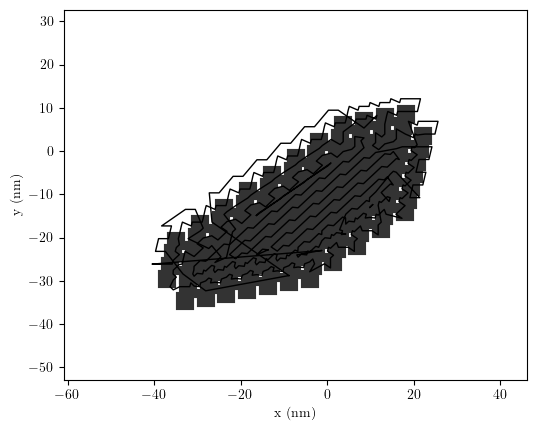

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


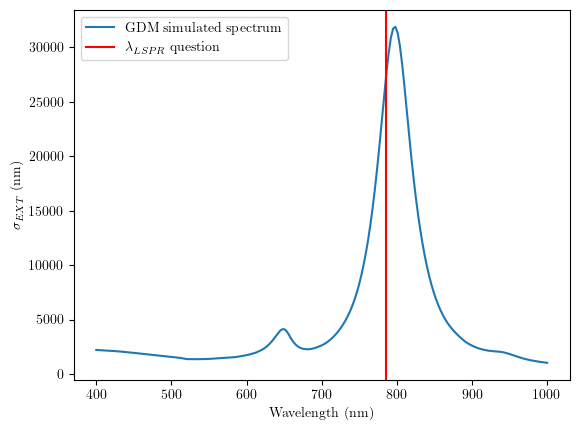

In [77]:
ls=dGenerated['length'][0]
h=dGenerated['heigth'][0]
edge=dGenerated['edge'][0]
ni=dGenerated['ni'][0]
ni=ni.astype(float)
thetax=dGenerated['thetax'][0]
thetay=dGenerated['thetay'][0]
thetaz=dGenerated['thetaz'][0]
wavelengths = np.linspace(400, 1000, 200)
GDMext=GDMsim(ls,h,edge,ni,thetax,thetay,thetaz,wavelengths,visualisation=True)
plt.figure()
plt.plot(wavelengths,GDMext,label='GDM simulated spectrum') 
plt.axvline(x=Qst_LSPR, color='red',label='$\lambda_{LSPR}$ question')
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\sigma_{EXT}$ (nm)')
plt.legend()

plt.show()


### GDM simulation on generated nanoprism

It is possible to make the same observations as for the sphere case:

1. The spectra, and thus the features, vary for the same question. This demonstrates the model's ability to generate new data.
2. The peak of each spectrum is close to the same wavelength as the question, illustrating the model's ability to answer the question accurately.

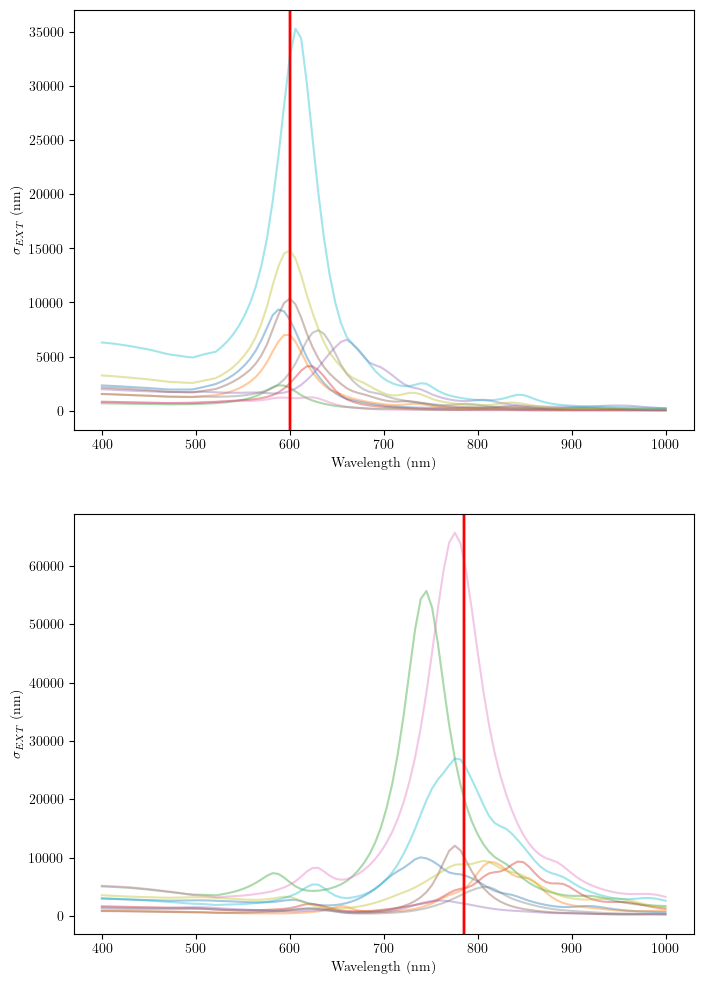

In [78]:
plt.figure(figsize=(8,12))
for i in range(10):
    Qst_LSPR1=600
    dGenerated=nprsm_gen(Qst_LSPR1,codings_size,consistency=1000,mean=[np.mean(z1),np.mean(z2)],stddev=[np.std(z1),np.std(z2)])
    ls=dGenerated['length'][0]
    h=dGenerated['heigth'][0]
    edge=dGenerated['edge'][0]
    ni=dGenerated['ni'][0].astype(float)
    thetax=dGenerated['thetax'][0]
    thetay=dGenerated['thetay'][0]
    thetaz=dGenerated['thetaz'][0]
    wavelengths = np.linspace(400, 1000, 100)
    GDMext=GDMsim(ls,h,edge,ni,thetax,thetay,thetaz,wavelengths)
    plt.subplot(211)
    plt.plot(wavelengths,GDMext,alpha=0.4,label='Ext. Mie spectrum')
    plt.axvline(x=Qst_LSPR1, color='red',label='VAE predicted LSPR')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$\sigma_{EXT}$ (nm)')

    Qst_LSPR3=785
    dGenerated=nprsm_gen(Qst_LSPR3,codings_size,consistency=1000,mean=[np.mean(z1),np.mean(z2)],stddev=[np.std(z1),np.std(z2)])
    ls=dGenerated['length'][0]
    h=dGenerated['heigth'][0]
    edge=dGenerated['edge'][0]
    ni=dGenerated['ni'][0].astype(float)
    thetax=dGenerated['thetax'][0]
    thetay=dGenerated['thetay'][0]
    thetaz=dGenerated['thetaz'][0]
    wavelengths = np.linspace(400, 1000, 100)
    GDMext=GDMsim(ls,h,edge,ni,thetax,thetay,thetaz,wavelengths)
    plt.subplot(212)
    plt.plot(wavelengths,GDMext,alpha=0.4,label='Ext. Mie spectrum')
    plt.axvline(x=Qst_LSPR3, color='red',label='VAE predicted LSPR')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$\sigma_{EXT}$ (nm)')

plt.show()

### Error Analysis

In this section, an analysis is performed to evaluate the errors between the LSPR given by a question and the LSPR generated with an answer.

Nanospheres are generated for each $\lambda_{LSPR_{question}}$ value, which range from 500nm to 800nm, and a corresponding extinction Spectrum is created with GDM simulations, the peak in the extinction cross-section ($Q_{ext}$) is identified and the corresponding wavelength ($\lambda_{LSPR_{answer}}$) is calculated.

This error is compared with the mean absolute error that is calculated as if the predicted $\lambda_{LSPR_{answer}}$ values were randomly chosen from within the studied range of wavelengths.

As observed the model's performance is more than twice as good as a random selection of a $\lambda_{LSPR}$ value.

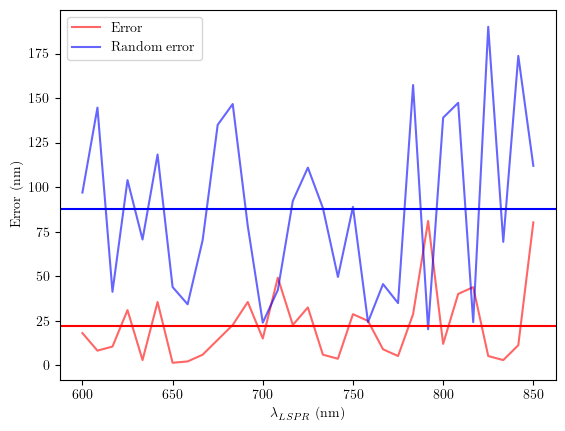

In [79]:
plt.figure()
err=[]
err_rand=[]
for i in np.linspace(600, 850, 31):

    dGenerated = nprsm_gen(i, codings_size, consistency=1000,stddev=np.std(z1)*0.2,mean=[np.mean(z1),np.mean(z2)])
    ls=dGenerated['length'][0]
    h=dGenerated['heigth'][0]
    edge=dGenerated['edge'][0]
    ni=dGenerated['ni'][0].astype(float)
    thetax=dGenerated['thetax'][0]
    thetay=dGenerated['thetay'][0]
    thetaz=dGenerated['thetaz'][0]
    wavelengths = np.linspace(400, 1000, 100)
    GDMext=GDMsim(ls,h,edge,ni,thetax,thetay,thetaz,wavelengths)
    peaks_ext,prop_ext=find_peaks(GDMext)
    max_peaks_ext=peaks_ext[np.argmax(GDMext[peaks_ext])]
    wl_mext=wavelengths[max_peaks_ext]
    err.append(np.abs(wl_mext-i))

    rand_wl=np.random.randint(600,850)
    err_rand.append(np.abs(rand_wl-i))
plt.plot(np.linspace(600, 850, 31), err, alpha=0.6, label='Error',color='red')
plt.plot(np.linspace(600, 850, 31), err_rand, alpha=0.6, label='Random error',color='blue')
plt.axhline(y=np.mean(err),color='red')
plt.axhline(y=np.mean(err_rand),color='blue')
plt.xlabel('$\lambda_{LSPR}$ (nm)')
plt.ylabel('Error (nm)')
plt.legend()

plt.show()


# Latent representation study

This script generates a series of extinction Spectra simulated by GDM and by utilizing a fixed latent vector (`zfix`) and varying the question (`LSPRqst`). As a comparison with sphere geometry, the spectra are much more chaotic.

The spectra corresponding to questions around 600nm are coded purple, and the color transitions to yellow for questions approaching 900nm.


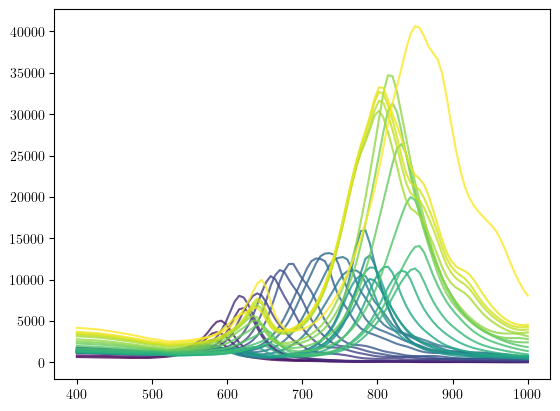

In [85]:
#chosing latent space and LSPR
z1fix=0
z2fix=0
LSPRfix=np.linspace(600,900,31).astype(np.int32)
wavelengths = np.linspace(400, 1000, 101)

norm = mcolors.Normalize(vmin=600, vmax=900) # Normalizing iteration values for the colormap
cmap = cm.ScalarMappable(norm=norm, cmap='viridis') # Creating the colormap

plt.figure()
for i in LSPRfix:
    i = tf.constant(i)
    ANSdecoded=variational_decoder((i,tf.reshape([z1fix,z2fix],[1,2]))).numpy()
    OBSdecoded=np.concatenate((ANSdecoded,np.array([[i]])),axis=1)

    GDMext=GDMsim(ANSdecoded[0,0],ANSdecoded[0,1],ANSdecoded[0,2],ANSdecoded[0,3].astype(float),ANSdecoded[0,4],ANSdecoded[0,5],ANSdecoded[0,6],wavelengths)
    plt.plot(wavelengths,GDMext,color=cmap.to_rgba(i), alpha=0.8, label='Ext. GDM spectrum')

plt.ylabel('$Q_{EXT}$')
plt.xlabel('Wavelength (nm)')
plt.show()